# Actividad 5: Visualización de Resultados y Variabilidad con Big Data (PySpark)

---

## 1. Proceso de validación cruzada y justificación de k

En esta sección se define el proceso de validación cruzada para evaluar la variabilidad y precisión de los modelos de aprendizaje automático aplicados al conjunto de datos de reseñas de libros.  
Partiendo de la muestra estratificada M (derivada de variables de caracterización 
de la población y construida en la Actividad 4), se selecciona la técnica de validación cruzada k-fold.

**Justificación del valor de k:**  
El valor de k determina el número de particiones (folds) en los que se divide la muestra M.  
Seleccionar un k demasiado pequeño, las divisiones no reflejan bien los datos ; si es muy grande, el procesamiento se vuelve muy costoso computacionalmente sobre todo en análisis de grandes volumenes de datos.
En este caso, optamos por un valor de k=5, ya que permite que cada fold contenga una cantidad suficiente de muestras de todos los estratos, logrando representatividad y eficiencia.
Esta elección se basa en la distribución de las clases y el tamaño de la muestra, permitiendo que la validación represente correctamente la diversidad del conjunto de datos.

In [1]:
# 1: Inicio de sesión en Spark e importación de librerías 
# Importar PySpark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, regexp_extract, rand, row_number, floor
from pyspark.sql.types import FloatType, IntegerType
from pyspark.sql.window import Window

# ML y transformación de datos
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Iniciar sesión Spark
spark = SparkSession.builder \
    .appName('BooksRatingDemo') \
    .config('spark.driver.memory', '4g') \
    .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

print("SparkSession iniciada correctamente.")

SparkSession iniciada correctamente.


## 2. Construcción de los k-folds estratificados

Esta sección implementa la creación de los k-folds siguiendo el enfoque de muestreo estratificado planteado en la Actividad 3.  
Cada fold se construye de manera que mantenga la proporción de las clases y estratos presentes en la muestra M. Esto ayuda a que cada grupo sea representativo y evita errores en el análisis.

Luego, se muestra el código que realiza esta partición y presentan los resultados para confirmar que los datos mantienen el equilibrio esperado.


In [3]:
# Cargar y limpiar la muestra M 
df = spark.read.option('header', 'true').csv('Books_rating.csv')
df = df.limit(5000)
df = df.filter(
    (col("review/score").isNotNull()) &
    (col("review/helpfulness").isNotNull()) &
    (col("user_id").isNotNull())
)
df = df.withColumn("Helpfulness_num_raw", regexp_extract(col("review/helpfulness"), r'^(\d+)', 1))
df = df.filter((col("Helpfulness_num_raw").isNotNull()) & (col("Helpfulness_num_raw") != ""))
df = df.withColumn("Helpfulness_num", col("Helpfulness_num_raw").cast(IntegerType()))
df = df.withColumn("Score_num", col("review/score").cast(FloatType()))
df = df.filter(col("Score_num").isNotNull())
df = df.drop("Helpfulness_num_raw")
df = df.withColumn("score_group", when(col("Score_num") >= 4, "Alta").otherwise("Baja"))
df = df.withColumn("helpfulness_group", when(col("Helpfulness_num") >= 8, "Alta").otherwise("Baja"))

# Agregar frecuencia de reseñas y categorización de usuario
user_reviews = df.groupBy("user_id").agg(count("user_id").alias("review_count"))
df = df.join(user_reviews, on="user_id", how="left")
df = df.withColumn(
    "user_group_detailed",
    when(col("review_count") >= 20, "20+ reseñas")
    .when((col("review_count") >= 10) & (col("review_count") < 20), "10-19 reseñas")
    .when((col("review_count") >= 5) & (col("review_count") < 10), "5-9 reseñas")
    .when((col("review_count") >= 2) & (col("review_count") < 5), "2-4 reseñas")
    .otherwise("1 reseña")
)

In [4]:
# Construcción de muestra M estratificada
from itertools import product
from pyspark.sql import functions as F
from functools import reduce

selected_columns = [
    "user_id", "review/helpfulness", "review/score", "review/summary",
    "Score_num", "Helpfulness_num", "user_group_detailed", "score_group", "helpfulness_group"
]
muestras = []
for s, h in product(["Alta", "Baja"], repeat=2):
    for u in ["20+ reseñas", "10-19 reseñas", "5-9 reseñas", "2-4 reseñas", "1 reseña"]:
        subset = df.filter(
            (col("score_group") == s) &
            (col("helpfulness_group") == h) &
            (col("user_group_detailed") == u)
        )
        muestra = subset.orderBy(F.rand()).select(*selected_columns).limit(30)
        muestras.append(muestra)
M = reduce(lambda a, b: a.unionByName(b), muestras)
M.cache()
M.show(10, truncate=False)

+--------------+------------------+------------+-------------------------------------------------------+---------+---------------+-------------------+-----------+-----------------+
|user_id       |review/helpfulness|review/score|review/summary                                         |Score_num|Helpfulness_num|user_group_detailed|score_group|helpfulness_group|
+--------------+------------------+------------+-------------------------------------------------------+---------+---------------+-------------------+-----------+-----------------+
|A1D2C0WDCSHUWZ|12/13             |5.0         |Fantasy classic                                        |5.0      |12             |5-9 reseñas        |Alta       |Alta             |
|AFVQZQ8PW0L   |11/16             |5.0         |entertaining unique look at the Greek culture          |5.0      |11             |5-9 reseñas        |Alta       |Alta             |
|A3M174IC0VXOS2|8/8               |5.0         |TREVOR, A COMMANDER OF LUMINOUS PROSE          

In [5]:
# Construcción de los k-folds
k = 5
window = Window.orderBy(rand())
M = M.withColumn("row_num", row_number().over(window))
M = M.withColumn("fold", ((M.row_num - 1) % k))
M.groupBy("fold", "score_group").count().orderBy("fold", "score_group").show()

+----+-----------+-----+
|fold|score_group|count|
+----+-----------+-----+
|   0|       Alta|   35|
|   0|       Baja|   17|
|   1|       Alta|   29|
|   1|       Baja|   23|
|   2|       Alta|   35|
|   2|       Baja|   17|
|   3|       Alta|   29|
|   3|       Baja|   22|
|   4|       Alta|   31|
|   4|       Baja|   20|
+----+-----------+-----+



## 3. Fase de entrenamiento (“Experimentación”)

En esta parte se lleva a cabo el entrenamiento del modelo seleccionado (por ejemplo, Random Forest, el mejor modelo identificado en la Actividad 4) para entrenarlo con los fols o grupo de datos creados antes.
Para cada fold se realiza el proceso de entrenamiento y validación, registrando las métricas de desempeño relevantes (accuracy, F1-score, precisión, recall, etc.).

El objetivo es ver qué tan bien funciona el modelo en distintas condiciones y medir la variablidiad de resultados.

In [6]:
# Indexado de variables categóricas
indexers = [
    StringIndexer(inputCol="score_group", outputCol="score_index"),
    StringIndexer(inputCol="user_group_detailed", outputCol="user_group_index"),
    StringIndexer(inputCol="helpfulness_group", outputCol="helpfulness_index")
]
for idx in indexers:
    M = idx.fit(M).transform(M)

# Ensamblado de features
assembler = VectorAssembler(
    inputCols=["Helpfulness_num", "user_group_index", "helpfulness_index"],
    outputCol="features"
)
M = assembler.transform(M)


In [7]:
# Validación cruzada y recolección de métricas
metrics = []
for fold in range(k):
    train_df = M.filter(M.fold != fold)
    test_df = M.filter(M.fold == fold)
    rf = RandomForestClassifier(featuresCol="features", labelCol="score_index", seed=42)
    model = rf.fit(train_df)
    predictions = model.transform(test_df)
    evaluator = MulticlassClassificationEvaluator(labelCol="score_index", predictionCol="prediction")
    fold_metrics = {
        "fold": fold,
        "accuracy": evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}),
        "f1": evaluator.evaluate(predictions, {evaluator.metricName: "f1"}),
        "precision": evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"}),
        "recall": evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"}),
    }
    metrics.append(fold_metrics)

import pandas as pd
metrics_df = pd.DataFrame(metrics)
display(metrics_df)

,fold,accuracy,f1,precision,recall
0,0,0.730769,0.726095,0.723701,0.730769
1,1,0.557692,0.523443,0.541827,0.557692
2,2,0.615385,0.623973,0.639490,0.615385
3,3,0.627451,0.583442,0.639589,0.627451
4,4,0.529412,0.517528,0.511765,0.529412


## 4. Resultados

En esta sección se presentan los datos obtenidos en el experimento, destacando gráficos que muestran el desempeño del modelo y como estan distribuidos los datos.

### 4.1 Estadísticas generales y distribución

Se incluyen estadisticas generales y la distribución de los grupos de datos, los gráficos ayudan a detectar posibles errores o desequilibrios en el muestreo.

In [8]:
# Estadísticas descriptivas de la muestra M
M_pd = M.select("Helpfulness_num", "Score_num", "user_group_detailed", "score_group", "helpfulness_group").toPandas()
display(M_pd.describe())

,Helpfulness_num,Score_num
count,258.000000,258.000000
mean,10.178295,3.763566
std,19.069788,1.381616
min,0.000000,1.000000
25%,1.000000,3.000000
50%,4.000000,4.000000
75%,12.000000,5.000000
max,162.000000,5.000000


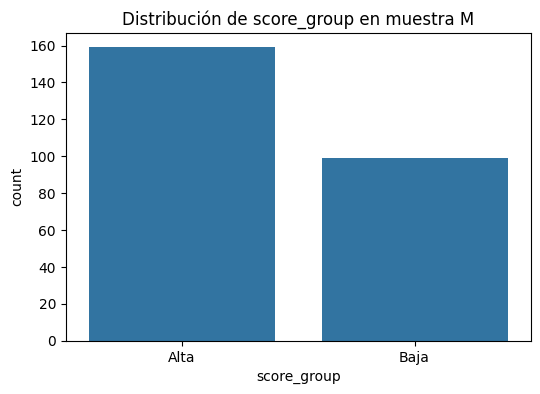

In [9]:
# Distribución por score_group
plt.figure(figsize=(6,4))
sns.countplot(x="score_group", data=M_pd)
plt.title("Distribución de score_group en muestra M")
plt.show()

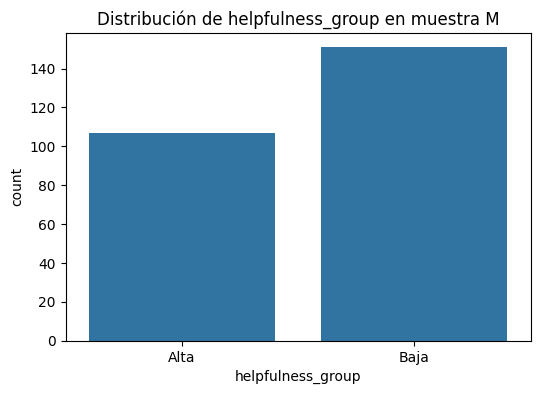

In [10]:
# Distribución por helpfulness_group
plt.figure(figsize=(6,4))
sns.countplot(x="helpfulness_group", data=M_pd)
plt.title("Distribución de helpfulness_group en muestra M")
plt.show()

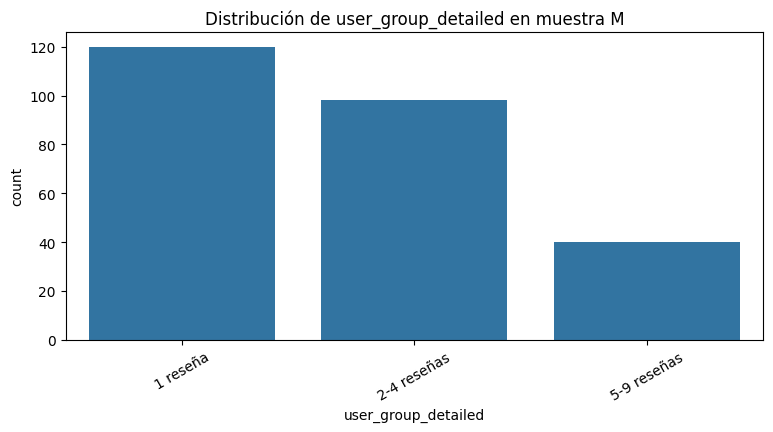

In [11]:
# Distribución por user_group_detailed
plt.figure(figsize=(9,4))
sns.countplot(x="user_group_detailed", data=M_pd, order=M_pd["user_group_detailed"].value_counts().index)
plt.title("Distribución de user_group_detailed en muestra M")
plt.xticks(rotation=30)
plt.show()

### 4.2 Métricas por fold
Se visualizan gráficos con los resultados del modelo, como precisión y rendimiento. Estos ayudan a análizar qué tan estable y variable es el modelo en distintos grupos de datos.

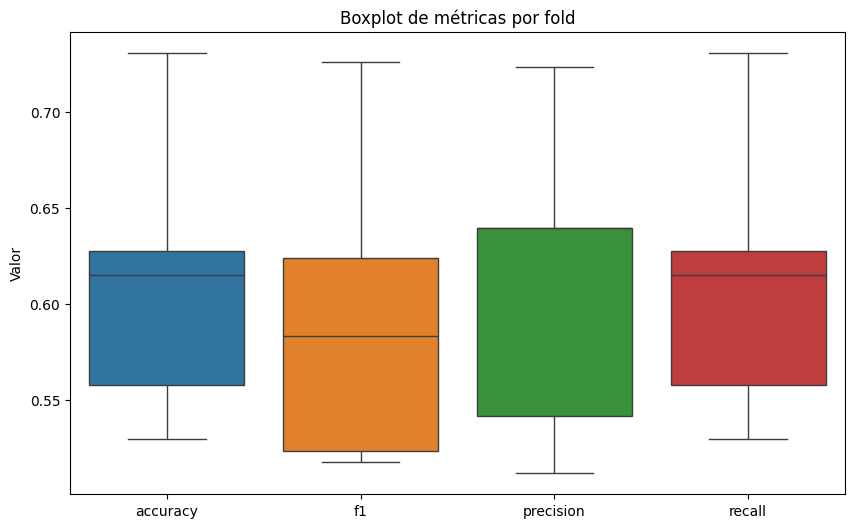

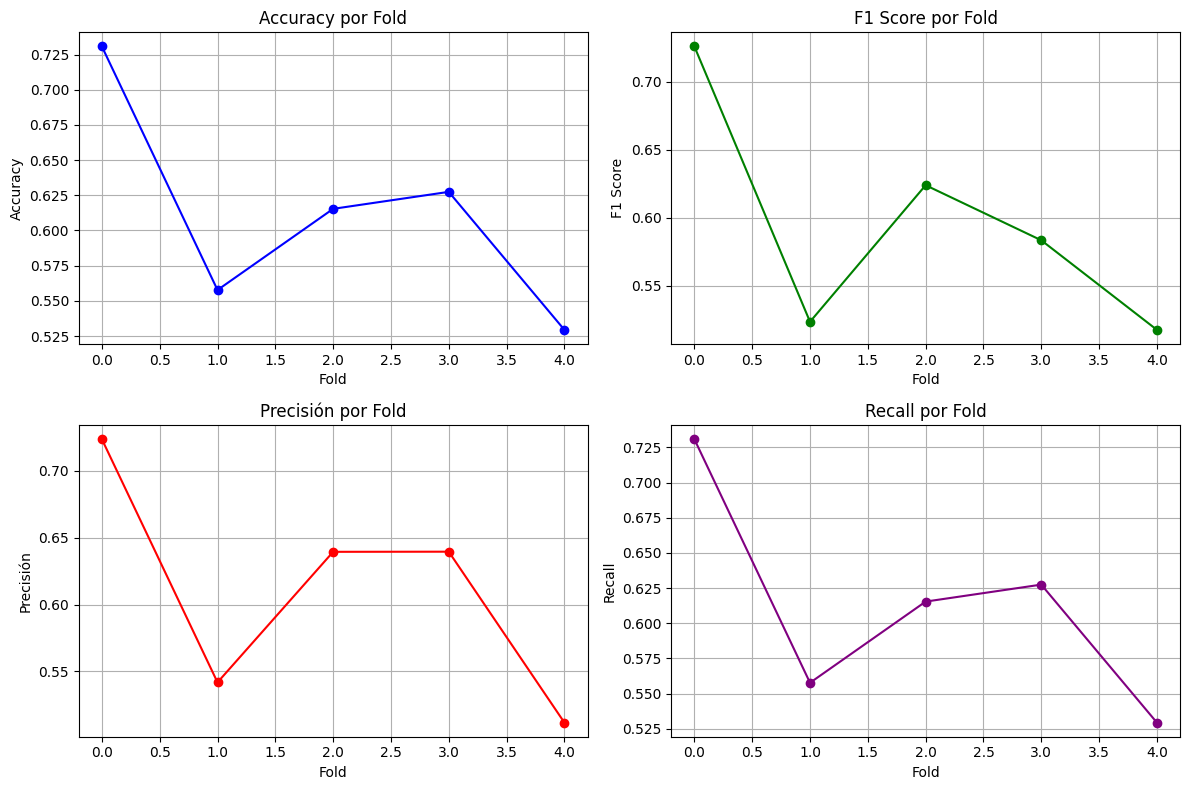

           fold  accuracy        f1  precision    recall
count  5.000000  5.000000  5.000000   5.000000  5.000000
mean   2.000000  0.612142  0.594896   0.611274  0.612142
std    1.581139  0.077663  0.085559   0.085092  0.077663
min    0.000000  0.529412  0.517528   0.511765  0.529412
25%    1.000000  0.557692  0.523443   0.541827  0.557692
50%    2.000000  0.615385  0.583442   0.639490  0.615385
75%    3.000000  0.627451  0.623973   0.639589  0.627451
max    4.000000  0.730769  0.726095   0.723701  0.730769


In [12]:
plt.figure(figsize=(10,6))
sns.boxplot(data=metrics_df[['accuracy','f1','precision','recall']])
plt.title("Boxplot de métricas por fold")
plt.ylabel("Valor")
plt.show()

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].plot(metrics_df['fold'], metrics_df['accuracy'], marker='o', color='b')
axs[0, 0].set_title('Accuracy por Fold')
axs[0, 0].set_xlabel('Fold'); axs[0, 0].set_ylabel('Accuracy'); axs[0, 0].grid(True)

axs[0, 1].plot(metrics_df['fold'], metrics_df['f1'], marker='o', color='g')
axs[0, 1].set_title('F1 Score por Fold')
axs[0, 1].set_xlabel('Fold'); axs[0, 1].set_ylabel('F1 Score'); axs[0, 1].grid(True)

axs[1, 0].plot(metrics_df['fold'], metrics_df['precision'], marker='o', color='r')
axs[1, 0].set_title('Precisión por Fold')
axs[1, 0].set_xlabel('Fold'); axs[1, 0].set_ylabel('Precisión'); axs[1, 0].grid(True)

axs[1, 1].plot(metrics_df['fold'], metrics_df['recall'], marker='o', color='purple')
axs[1, 1].set_title('Recall por Fold')
axs[1, 1].set_xlabel('Fold'); axs[1, 1].set_ylabel('Recall'); axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

print(metrics_df.describe())

### 4.3 Matriz de confusión

Se muestra una matriz de confusión que resume el desempeño del modelo, destacando aciertos y errores en la clasificación.

In [13]:
!pip install scikit-learn
import warnings
warnings.filterwarnings('ignore')

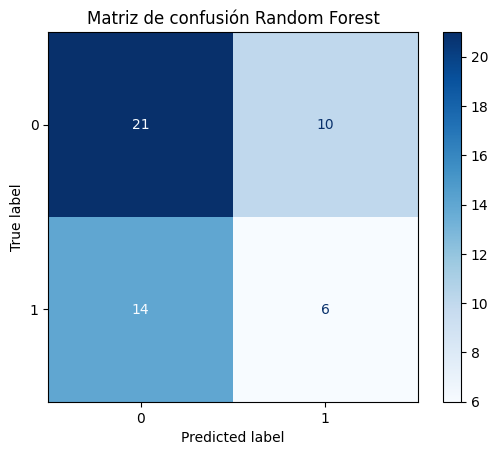

In [14]:
# 4.3 Matriz de confusión

# Importar sklearn para matriz de confusión
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Se toma el ultimo fold como ejemplo para promediar 
pred_fold = model.transform(test_df)
y_true = pred_fold.select("score_index").toPandas().astype(int)
y_pred = pred_fold.select("prediction").toPandas().astype(int)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Matriz de confusión Random Forest")
plt.show()

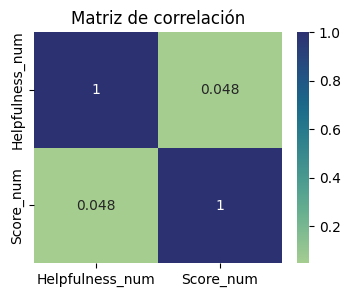

In [15]:
# Heatmap de correlación
corr = M_pd[["Helpfulness_num","Score_num"]].corr()
plt.figure(figsize=(4,3))
sns.heatmap(corr, annot=True, cmap='crest')
plt.title('Matriz de correlación')
plt.show()

## 5. Discusión de Resultados y Conclusiones

**Robustez y representatividad de la muestra:**  
La muestra M fue construida mediante un muestreo estratificado, para garantizar que todos los grupos importantes estuvieran bien representados. Esto ayuda a obtener resultados confiables y equilibrados en cada etapa del análisis.

**Desempeño del modelo y matriz de confusión:**  
El modelo Random Forest se entrenó y evaluó mediante validación cruzada k-fold, permitiendo medir la variabilidad y estabilidad de las métricas de desempeño.  
La matriz de confusión presentada muestra la cantidad de aciertos y errores en cada clase (por ejemplo, `Alta` vs `Baja`) para el fold evaluado. 

**Interpretación de los resultados:**  
- Si la mayoría de los valores estan en la diagonal,el modelo distingue bien las clases.
- Si hay errores fuera de la diagonal, puede necesitar mejoras, como más datos o ajustes de parámetros. 
- Un buen desempeño en la matriz de confusión, junto con métricas de accuracy, F1 y recall estables entre los folds sigifica que el modelo es confiable y sin sesgos.

**Variabilidad y significancia:**  
La validación cruzada ayuda a estimar qué tan consistentes serán los resultados si aplicamos el modelo a nuevos datos. Si las métricas son estables , el modelo es sólido y los resultados no son producto del  azar.

**Conclusión final:**  
El análisis de las calificaciones de libros, realizado con validación cruzada y un modelo Random Forest, permitió evaluar qué tan bien se puede predecir si una reseña corresponde a una calificación alta o baja. La matriz de confusión fue clave para interpretar los resultados en cada etapa de validación.
Los resultados muestran que el modelo funciona bien al diferenciar reseñas con calificaciones altas y bajas. La mayoría de las predicciones fueron correctas, pero aún hay algunos casos en los que el modelo se confunde, sobre todo cuando las características de las reseñas no ofrecen información clara para distinguirlas.
Además, al analizar métricas como accuracy, F1, precisión y recall, se observó que el rendimiento del modelo es constante y no varía significativamente entre los distintos pliegues de validación. Esto indica que el modelo generaliza bien y no está sobreajustado.
En resumen, el proceso de análisis utilizado—desde la limpieza de datos hasta la visualización de resultados—permitió desarrollar un modelo sólido para predecir la calificación de las reseñas de libros. La matriz de confusión no solo ayudó a entender los aciertos y errores del modelo, sino que también reveló patrones que podrían servir para mejorar futuras versiones del análisis.


In [16]:
#finalizar sapark
spark.stop()
print("Sesión de Spark finalizada correctamente.")

Sesión de Spark finalizada correctamente.
